<a href="https://colab.research.google.com/github/rohan1907/StumbleUpon-Evergreen-Classification-Challenge/blob/main/Evergreen%20Classification%20challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd 
import numpy as np 
import tensorflow_hub as hub
import matplotlib.pyplot as plt 
import seaborn as sns 
%matplotlib inline 

import tensorflow as tf 

In [2]:
# taking all columns of training set only for data exploration
df_train=pd.read_csv('/content/data/train.tsv',sep='\t')
# taking boilerplate column as an input for the model beacuse only this column contain lot of high quality text data useful for our nlp task
df_test=pd.read_csv('/content/data/test.tsv',sep='\t', usecols=['urlid','boilerplate'])


In [3]:
df_train['boilerplate'].replace(to_replace=r'"title":', value="",inplace=True,regex=True)
df_train['boilerplate'].replace(to_replace=r'"url":',value="",inplace=True,regex=True)

df_train['boilerplate'].replace(to_replace=r'{|}',value="",inplace=True,regex=True)
df_train['boilerplate']=df_train['boilerplate'].str.lower()

#Cleaning the test dataframe 

df_test['boilerplate'].replace(to_replace=r'"title":', value="",inplace=True,regex=True)
df_test['boilerplate'].replace(to_replace=r'"url":',value="",inplace=True,regex=True)

df_test['boilerplate'].replace(to_replace=r'{|}',value="",inplace=True,regex=True)
df_test['boilerplate']=df_test['boilerplate'].str.lower()

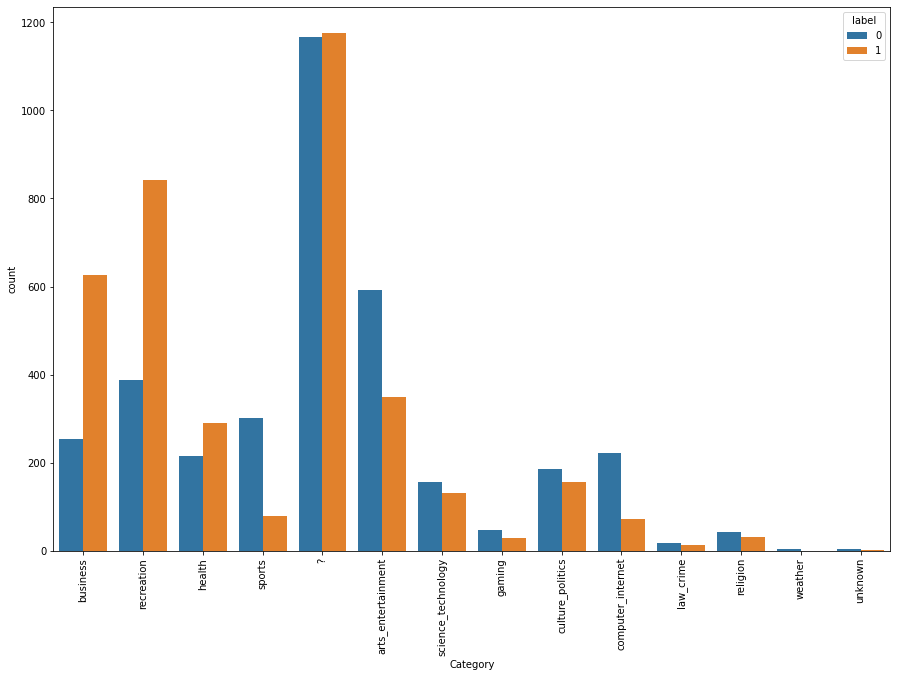

In [5]:
plt.figure(figsize=(15,10))
sns.countplot(x=df_train['alchemy_category'],hue=df_train['label']);
plt.xlabel('Category');
plt.xticks(rotation=90);

In [4]:
text_train = df_train.boilerplate 
text_test = df_test.boilerplate
urlid_test = df_test.urlid
y_train = df_train.label.values

In [5]:
model = "https://tfhub.dev/google/nnlm-en-dim50/2"
hub_layer = hub.KerasLayer(model, input_shape=[], dtype=tf.string, trainable=True)

In [6]:
model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(64,activation='relu'))
model.add(tf.keras.layers.Dense(1,activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 50)                48190600  
_________________________________________________________________
batch_normalization (BatchNo (None, 50)                200       
_________________________________________________________________
dense (Dense)                (None, 128)               6528      
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 48,205,649
Trainable params: 48,205,549
Non-trainable params: 100
__________________________________________

In [7]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer='adam',metrics=[tf.keras.metrics.AUC()])

In [8]:
x_val = text_train[:3000]
partial_x_train = text_train[3000:]

y_val = y_train[:3000]
partial_y_train = y_train[3000:]
text_train[:3]

0    "ibm sees holographic calls air breathing batt...
1    "the fully electronic futuristic starting gun ...
2    "fruits that fight the flu fruits that fight t...
Name: boilerplate, dtype: object

In [9]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=40,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/40
9/9 [==============================] - 2s 162ms/step - loss: 0.6378 - auc: 0.6985 - val_loss: 0.5724 - val_auc: 0.8290
Epoch 2/40
9/9 [==============================] - 1s 108ms/step - loss: 0.5148 - auc: 0.8388 - val_loss: 0.5492 - val_auc: 0.8451
Epoch 3/40
9/9 [==============================] - 1s 108ms/step - loss: 0.4766 - auc: 0.8684 - val_loss: 0.5165 - val_auc: 0.8563
Epoch 4/40
9/9 [==============================] - 1s 109ms/step - loss: 0.4399 - auc: 0.8859 - val_loss: 0.5110 - val_auc: 0.8612
Epoch 5/40
9/9 [==============================] - 1s 111ms/step - loss: 0.3956 - auc: 0.9076 - val_loss: 0.5033 - val_auc: 0.8652
Epoch 6/40
9/9 [==============================] - 1s 107ms/step - loss: 0.3722 - auc: 0.9171 - val_loss: 0.4938 - val_auc: 0.8674
Epoch 7/40
9/9 [==============================] - 1s 108ms/step - loss: 0.3304 - auc: 0.9363 - val_loss: 0.4830 - val_auc: 0.8679
Epoch 8/40
9/9 [==============================] - 1s 110ms/step - loss: 0.2886 - auc: 0.95

In [10]:
predictions=model.predict(text_test)

In [11]:
val=[1 if i>=0.5 else 0 for i in predictions]

In [12]:
df_test['label']=val

df_test.to_csv('submissions.csv',columns=['urlid','label'],index=False)

In [13]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'auc', 'val_loss', 'val_auc'])

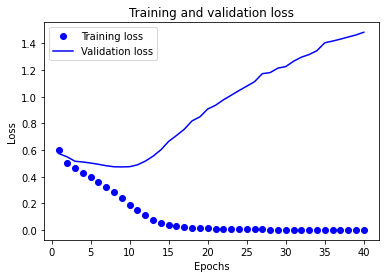

In [14]:
acc = history_dict['auc']
val_acc = history_dict['val_auc']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

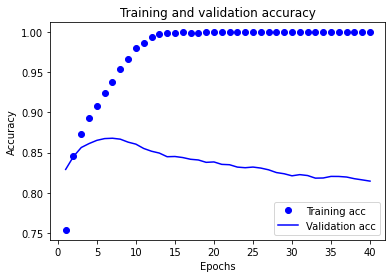

In [15]:
plt.clf()   # clear figure

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()